### Jupyter notebook for applying/testing this algorithm

Emily Luschen, emily.w.luschen-1@ou.edu  
James Ruppert, jruppert@ou.edu  
5/19/23

In [1]:
import numpy as np
from netCDF4 import Dataset,num2date
import matplotlib.pyplot as plt
from matplotlib import colors, ticker, rc
import os
import cartopy.crs as ccrs
from wrf import getvar, disable_xarray
from precip_class import precip_class
from thermo_functions import density_moist
from cfads_functions import mask_edges

In [2]:
# #### Main settings

# #### Variable selection

storm = 'haiyan'
# storm = 'maria'

# How many members
memb_str = 'memb_01' # Which member to plot?

# Time step to plot (CTL)
it_read = 36

In [3]:
# #### Directories

main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/"
figdir = "/home/jamesrup/figures/tc/ens/mse/"

# Tests to compare
if storm == 'haiyan':
    tests = ['ctl','ncrf36h']
elif storm == 'maria':
    # tests = ['ctl','ncrf36h']
    tests = ['ctl','ncrf48h']
# tests = ['crfon','ncrf']

if tests[1] == 'ncrf36h':
    t01=36
    t02=0
elif tests[1] == 'ncrf48h':
    t0=48
    t02=0
elif tests[1] == 'crfon':
    t0=0
    t02=48

testdir = main+storm+'/'+memb_str+'/'+tests[0]+'/'
testdir2 = main+storm+'/'+memb_str+'/'+tests[1]+'/'

# WRFOUT file list
dirlist = os.listdir(testdir)
subs="wrfout_d02"
wrf_files = list(filter(lambda x: subs in x, dirlist))
wrf_files.sort()
wrf_files = [testdir + s for s in wrf_files]
nwrf=len(wrf_files)
wrfout1 = wrf_files[t01]
ncfile = Dataset(wrfout1)
ni = ncfile.dimensions['west_east'].size
nj = ncfile.dimensions['south_north'].size
nz = ncfile.dimensions['bottom_top'].size
ncfile.close()

dirlist = os.listdir(testdir2)
subs="wrfout_d02"
wrf_files = list(filter(lambda x: subs in x, dirlist))
wrf_files.sort()
wrf_files = [testdir + s for s in wrf_files]
nwrf=len(wrf_files)
wrfout2 = wrf_files[t02]

### Read variables and conduct classification
---

In [4]:
# Read function
def var_read(infile, varname):
    ncfile = Dataset(infile)
    var = ncfile.variables[varname][...]
    ncfile.close()
    var = np.squeeze(var)
    var = mask_edges(var)
    return var

def var_wrfread(infile, varname):
    disable_xarray()
    ncfile = Dataset(infile)
    var = getvar(ncfile, varname)
    ncfile.close()
    var = np.squeeze(var)
    var = mask_edges(var)
    return var

def qvar_read(infile, dp):
    # Read in and vertically integrate mixing ratios
    q_list = ['QCLOUD', 'QRAIN','QICE', 'QSNOW', 'QGRAUP']
    g = 9.81 # m/s^2
    nvar = len(q_list)
    q_var = []
    for ivar in range(nvar):
        ivar = var_read(infile,q_list[ivar]) # kg/kg
        q_var.append(ivar)
    q_var = np.stack(q_var, axis=0)
    q_int = np.sum(q_var*dp, axis=1)/(-g)
    return q_var, q_int

In [5]:
def class_variables(wrffile, it_read):

    # Read in hydrostatic pressure to get dp for integral
    p_hyd = var_read(wrffile,'P_HYD') # Pa
    p_hyd = np.ma.masked_where((p_hyd < 100e2), p_hyd, copy=False) # Mask out levels above 100 hPa
    dp = np.gradient(p_hyd, axis=0, edge_order=1) # [Pa] Uses second order centered differencing

    # Run new classification
    q_var, q_int = qvar_read(wrffile, dp)
    c_type = precip_class(q_int)
    c_type = mask_edges(c_type)
    #   0: non-precipitating
    # Convective:
    #   1: deep convective
    #   2: congestus
    #   3: shallow
    # Layered:
    #   4: stratiform
    #   5: anvil (weaker rainfall)

    # Traditional classification scheme
    #   Fortran code to calculate this from same model output courtesy of
    #   Rosi Rios-Berrios (NCAR), who wrote it based on Rogers (2010, JAS)
    pclass_trad = testdir+'post/d02/strat.nc'
    varfil_main = Dataset(pclass_trad)
    c_type_og = varfil_main.variables['strat'][it_read,...]
    varfil_main.close()
    c_type_og = np.squeeze(c_type_og)
    c_type_og = mask_edges(c_type_og)
    #  0: non-precipitating
    #  1: convective
    #  2: stratiform
    #  3: "other" (assumed to be anvil)

    return p_hyd, dp, q_var, c_type, c_type_og

In [6]:
def misc_variables(wrffile, p_hyd):

    # Vertical motion [m/s]
    varname='wa'
    w = var_wrfread(wrffile,varname) # wrf.getvar interpolates onto mass grid

    # Various necessary vars
    varname='tk'
    tmpk = var_wrfread(wrffile,varname) # Temperature [K]; wrf.getvar adds base state
    varname='QVAPOR'
    qv = var_read(wrffile,varname) # Water vapor mixing ratio [kg/kg]

    rho = density_moist(tmpk, qv, p_hyd)

    return w, tmpk, qv, rho

### Read additional variables for assessment of classification scheme
---

In [7]:
def rad_tend(wrffile):

    # Radiative tendencies [K/s]
    varname='RTHRATLW'
    lw = var_read(wrffile,varname)*3600*24 # K/s --> K/d
    varname='RTHRATLWC'
    lwc = var_read(wrffile,varname)*3600*24 # K/s --> K/d
    varname='RTHRATSW'
    sw = var_read(wrffile,varname)*3600*24 # K/s --> K/d
    varname='RTHRATSWC'
    swc = var_read(wrffile,varname)*3600*24 # K/s --> K/d
    crf = sw + lw - lwc - swc

    # Vertically integrated radiative terms
    lw_t = var_read(wrffile,'LWUPT') - var_read(wrffile,'LWDNT') # W/m2
    lw_b = var_read(wrffile,'LWUPB') - var_read(wrffile,'LWDNB') # W/m2
    lw_net = lw_b - lw_t
    # Clear sky
    lw_tc = var_read(wrffile,'LWUPTC') - var_read(wrffile,'LWDNTC') # W/m2
    lw_bc = var_read(wrffile,'LWUPBC') - var_read(wrffile,'LWDNBC') # W/m2 = J/m2/s
    lw_net_cs = lw_bc - lw_tc
    acre = lw_net - lw_net_cs

    return crf, lw_net, lw_net_cs

In [8]:
# Dry and moist static energy (DSE, MSE), J/kg
def static_energies(wrffile, tmpk, qv, dp):

    # Various necessary vars
    varname='geopt'
    ph = var_wrfread(wrffile,varname) # Geopotential = g*z; wrf.getvar interpolates onto mass grid

    # ;LATENT HEAT OF VAPORIZATION
    cp=1004.  # J/K/kg
    cpl=4186. # J/k/kg
    cpv=1885. # J/K/kg
    lv0=2.5e6 # J/kg
    lv = lv0 - (cpl-cpv)*(tmpk-273.15)

    # Dry static energy (DSE)
    dse_z = cp*tmpk + ph
    # Moist static energy (MSE)
    mse_z = dse_z + lv*qv

    return dse_z, mse_z

In [9]:
def mse_variance(mse, lw_net, lw_net_cs):

    # MSE variance terms

    # Remove means
    mse_mean = np.mean(mse)
    mse_p = mse - mse_mean
    lw_mean = np.mean(lw_net)
    lw_p = lw_net - lw_mean
    lw_mean_cs = np.mean(lw_net_cs)
    lw_p_cs = lw_net_cs - lw_mean_cs

    # Calculate covariance
    lwmse = mse_p*lw_p # J/m2 * J/m2/s = (J/m2)^2 / s
    msevar = np.var(mse) # (J/m2)^2
    lwmse /= msevar # units = /s
    lwmse *= 3600*24 # /s --> /day

    # Clear-sky
    lwmse_cs = mse_p*lw_p_cs # J/m2 * J/m2/s = (J/m2)^2 / s
    lwmse_cs /= msevar # units = /s
    lwmse_cs *= 3600*24 # s/day * /s = /day

    return lwmse, lwmse_cs

In [10]:
def vertical_int(var, dp):
    g=9.81 # m/s^2
    return np.sum(var*dp, axis=0)/(-g)

In [11]:
# Run first test

p_hyd, dp, q_var, c_type, c_type_og = class_variables(wrfout1, t01)
w, tmpk, qv, rho = misc_variables(wrfout1, p_hyd)
crf, lw_net, lw_net_cs = rad_tend(wrfout1)
dse_z, mse_z = static_energies(wrfout1, tmpk, qv, dp)
dse = vertical_int(dse_z, dp)
mse = vertical_int(mse_z, dp)
lwmse, lwmse_cs = mse_variance(mse, lw_net, lw_net_cs)

In [12]:
# # Run second test

# p_hyd2, dp2, q_var2, c_type2, c_type_og2, w2 = misc_variables(wrfout2, t02)
# crf2, lw_net2, lw_net_cs2 = rad_tend(wrfout2)
# dse_z2, dse2, mse_z2, mse2 = static_energies(wrfout2, dp2)
# lwmse2, lwmse_cs2 = mse_variance(mse2, lw_net2, lw_net_cs2)

### Classification-based statistics
---

In [13]:
def area_stats(label, total, npts):
    print('number of '+label+' points: ', total,'; domain fraction: ', 
        np.round(1e2*total/npts, decimals=2), '%')

In [14]:
print('Area fractions of each class:')
print()
print('New classification:')
print()
area_stats('deep convective', np.sum(c_type==1), nj*ni)
area_stats('congestus', np.sum(c_type==2), nj*ni)
area_stats('shallow convective', np.sum(c_type==3), nj*ni)
area_stats('stratiform', np.sum(c_type==4), nj*ni)
area_stats('anvil', np.sum(c_type==5), nj*ni)
area_stats('all-precip', np.sum(c_type > 0), nj*ni)
area_stats('non-raining', np.sum(c_type==0), nj*ni)

Area fractions of each class:

New classification:

number of deep convective points:  9097 ; domain fraction:  1.02 %
number of congestus points:  8957 ; domain fraction:  1.01 %
number of shallow convective points:  23461 ; domain fraction:  2.64 %
number of stratiform points:  43803 ; domain fraction:  4.93 %
number of anvil points:  41337 ; domain fraction:  4.66 %
number of all-precip points:  126655 ; domain fraction:  14.26 %
number of non-raining points:  476545 ; domain fraction:  53.66 %


In [15]:
print('Traditional classification:')
print()
area_stats('convective', np.sum(c_type_og==1), nj*ni)
area_stats('stratiform', np.sum(c_type_og==2), nj*ni)
area_stats('anvil', np.sum(c_type_og==3), nj*ni)
area_stats('all-precip', np.sum(c_type_og > 0), nj*ni)
area_stats('non-raining', np.sum(c_type_og==0), nj*ni)

Traditional classification:

number of convective points:  18700 ; domain fraction:  2.11 %
number of stratiform points:  30294 ; domain fraction:  3.41 %
number of anvil points:  27017 ; domain fraction:  3.04 %
number of all-precip points:  76011 ; domain fraction:  8.56 %
number of non-raining points:  527189 ; domain fraction:  59.37 %


In [16]:
def mse_stats_class(label, ind):
    total = np.sum(lwmse[ind[0],ind[1]])/ind[0].shape[0]*1e2
    print(label+' points: ', np.round(total, decimals=2), 'W/m^2')

In [17]:
# Masked LWMSE terms
print("Sum(LW'MSE') over class normalized by class area")
print()
print('New classification:')
print()
mse_stats_class('deep convective', (c_type==1).nonzero())
mse_stats_class('congestus', (c_type==2).nonzero())
mse_stats_class('shallow convective', (c_type==3).nonzero())
mse_stats_class('stratiform', (c_type==4).nonzero())
mse_stats_class('anvil', (c_type==5).nonzero())
mse_stats_class('all-precip', (c_type > 0).nonzero())
mse_stats_class('non-raining', (c_type==0).nonzero())

Sum(LW'MSE') over class normalized by class area

New classification:

deep convective points:  59.76 W/m^2
congestus points:  -4.72 W/m^2
shallow convective points:  4.07 W/m^2
stratiform points:  52.26 W/m^2
anvil points:  34.69 W/m^2
all-precip points:  34.11 W/m^2
non-raining points:  4.75 W/m^2


In [18]:
print('Traditional classification:')
print()
mse_stats_class('convective', (c_type_og==1).nonzero())
mse_stats_class('stratiform', (c_type_og==2).nonzero())
mse_stats_class('anvil', (c_type_og==3).nonzero())
mse_stats_class('all-precip', (c_type_og > 0).nonzero())
mse_stats_class('non-raining', (c_type_og==0).nonzero())

Traditional classification:

convective points:  25.08 W/m^2
stratiform points:  41.47 W/m^2
anvil points:  21.86 W/m^2
all-precip points:  30.47 W/m^2
non-raining points:  8.09 W/m^2


In [19]:
def mse_stats_domain(label, ind, npts):
    total = np.sum(lwmse[ind[0],ind[1]])/npts
    print(label+' points: ', np.round(total, decimals=3), 'W/m^2')

In [20]:
print("Sum(LW'MSE') over class normalized by total domain area")
print()
print('New classification:')
print()
mse_stats_domain('deep convective', (c_type==1).nonzero(), nj*ni)
mse_stats_domain('congestus', (c_type==2).nonzero(), nj*ni)
mse_stats_domain('shallow convective', (c_type==3).nonzero(), nj*ni)
mse_stats_domain('stratiform', (c_type==4).nonzero(), nj*ni)
mse_stats_domain('anvil', (c_type==5).nonzero(), nj*ni)
mse_stats_domain('all-precip', (c_type > 0).nonzero(), nj*ni)
mse_stats_domain('non-raining', (c_type==0).nonzero(), nj*ni)

Sum(LW'MSE') over class normalized by total domain area

New classification:

deep convective points:  0.006 W/m^2
congestus points:  -0.0 W/m^2
shallow convective points:  0.001 W/m^2
stratiform points:  0.026 W/m^2
anvil points:  0.016 W/m^2
all-precip points:  0.049 W/m^2
non-raining points:  0.025 W/m^2


In [21]:
print('Traditional classification:')
print()
mse_stats_domain('convective', (c_type_og==1).nonzero(), nj*ni)
mse_stats_domain('stratiform', (c_type_og==2).nonzero(), nj*ni)
mse_stats_domain('anvil', (c_type_og==3).nonzero(), nj*ni)
mse_stats_domain('all-precip', (c_type_og > 0).nonzero(), nj*ni)
mse_stats_domain('non-raining', (c_type_og==0).nonzero(), nj*ni)

Traditional classification:

convective points:  0.005 W/m^2
stratiform points:  0.014 W/m^2
anvil points:  0.007 W/m^2
all-precip points:  0.026 W/m^2
non-raining points:  0.048 W/m^2


## Plot results
---

In [22]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 14}

rc('font', **font)

#### Map of classifications

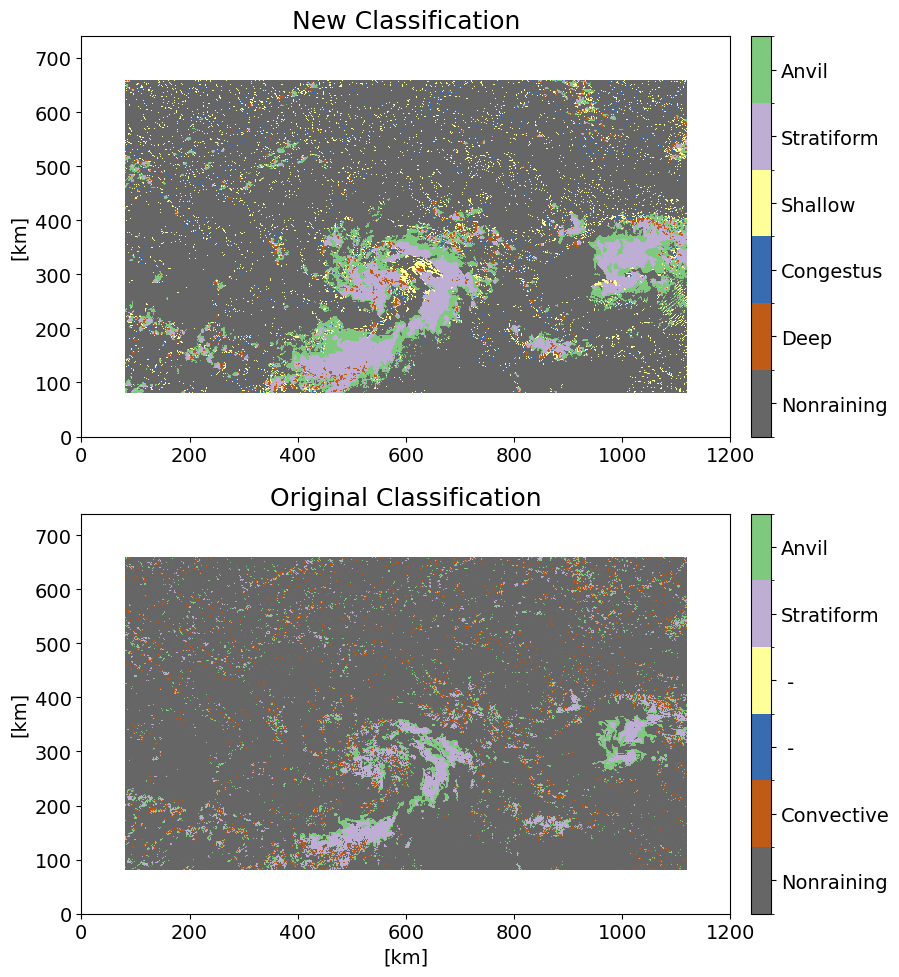

In [23]:
bounds = np.array([-0.5, .5, 1.5, 2.5, 3.5, 4.5, 5.5])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=6)
nlevs = len(bounds) - 1
cmap = plt.get_cmap('Accent_r', nlevs)

fig = plt.figure(figsize=(12,10))
fig.set_facecolor('white')

ax = fig.add_subplot(211, aspect='equal')
plt.pcolormesh(c_type, cmap=cmap, norm=norm)
cbar=plt.colorbar(fraction=0.03, pad=0.02, ticks=(0,1,2,3,4,5))
cbar.set_ticklabels(['Nonraining','Deep', 'Congestus', 'Shallow', 'Stratiform', 'Anvil'])
cbar.ax.tick_params(labelsize=14)
ax.set_ylabel('[km]')
ax.set_title("New Classification", size=18)

c_type_og2 = np.ma.copy(c_type_og)
c_type_og2[(c_type_og >= 2)] += 2

ax = fig.add_subplot(212,aspect='equal')
plt.pcolormesh(c_type_og2, cmap=cmap, norm=norm)
cbar=plt.colorbar(fraction=0.03, pad=0.02, ticks=(0,1,2,3,4,5))
cbar.set_ticklabels(['Nonraining','Convective',' - ',' - ','Stratiform','Anvil'])
cbar.ax.tick_params(labelsize=14)
ax.set_xlabel('[km]')
ax.set_ylabel('[km]')
ax.set_title("Original Classification", size=18)
plt.tight_layout()

#### Maps of MSE-LW variance masked by class

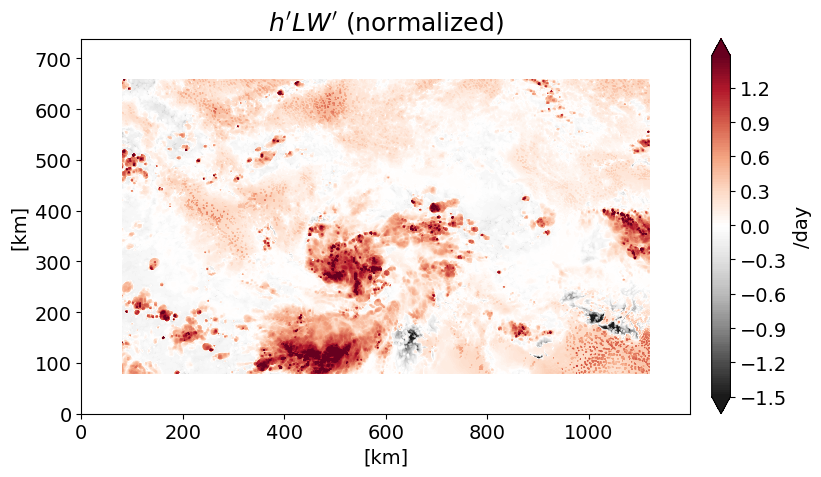

In [24]:
# Unmasked

fig = plt.figure(figsize=(12,5))
fig.set_facecolor('white')

clevs = np.arange(-1.5,1.5,0.02)
ax = fig.add_subplot(111, aspect='equal')
plt.contourf(lwmse, clevs, cmap='RdGy_r', extend='both', zorder=1)
cbar=plt.colorbar(fraction=0.03, pad=0.02)
cbar.set_label('/day')
ax.set_xlabel('[km]')
ax.set_ylabel('[km]')
ax.set_title("$h'LW'$ (normalized)", size=18)
plt.tight_layout()

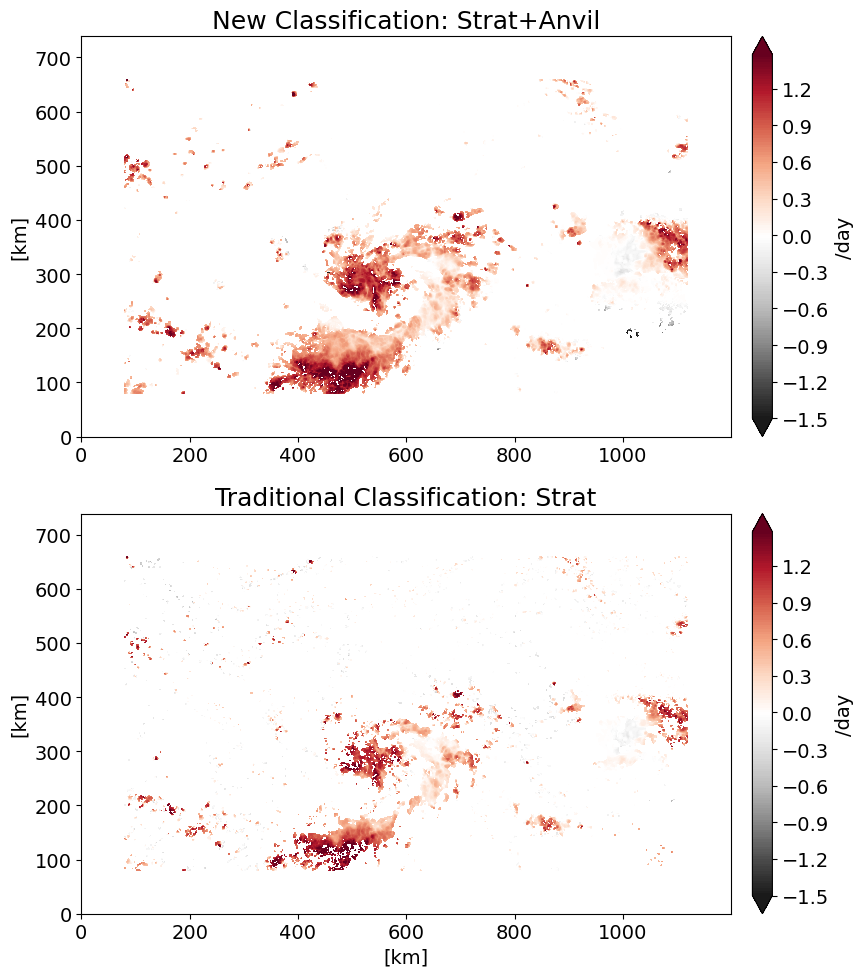

In [25]:
# Stratiform

fig = plt.figure(figsize=(12,10))
fig.set_facecolor('white')

clevs = np.arange(-1.5,1.5,0.02)

# New classification
lwmse_mask = np.ma.masked_where((c_type < 4), lwmse, copy=True)
ax = fig.add_subplot(211,aspect='equal')
plt.contourf(lwmse_mask, clevs, cmap='RdGy_r', extend='both', zorder=1)
cbar=plt.colorbar(fraction=0.03, pad=0.02)
cbar.set_label('/day')
ax.set_ylabel('[km]')
ax.set_title("New Classification: Strat+Anvil", size=18)

# Traditional classification
lwmse_mask = np.ma.masked_where((c_type_og < 2), lwmse, copy=True)
ax = fig.add_subplot(212,aspect='equal')
plt.contourf(lwmse_mask, clevs, cmap='RdGy_r', extend='both', zorder=1)
cbar=plt.colorbar(fraction=0.03, pad=0.02)
cbar.set_label('/day')
ax.set_xlabel('[km]')
ax.set_ylabel('[km]')
ax.set_title("Traditional Classification: Strat", size=18)

plt.tight_layout()

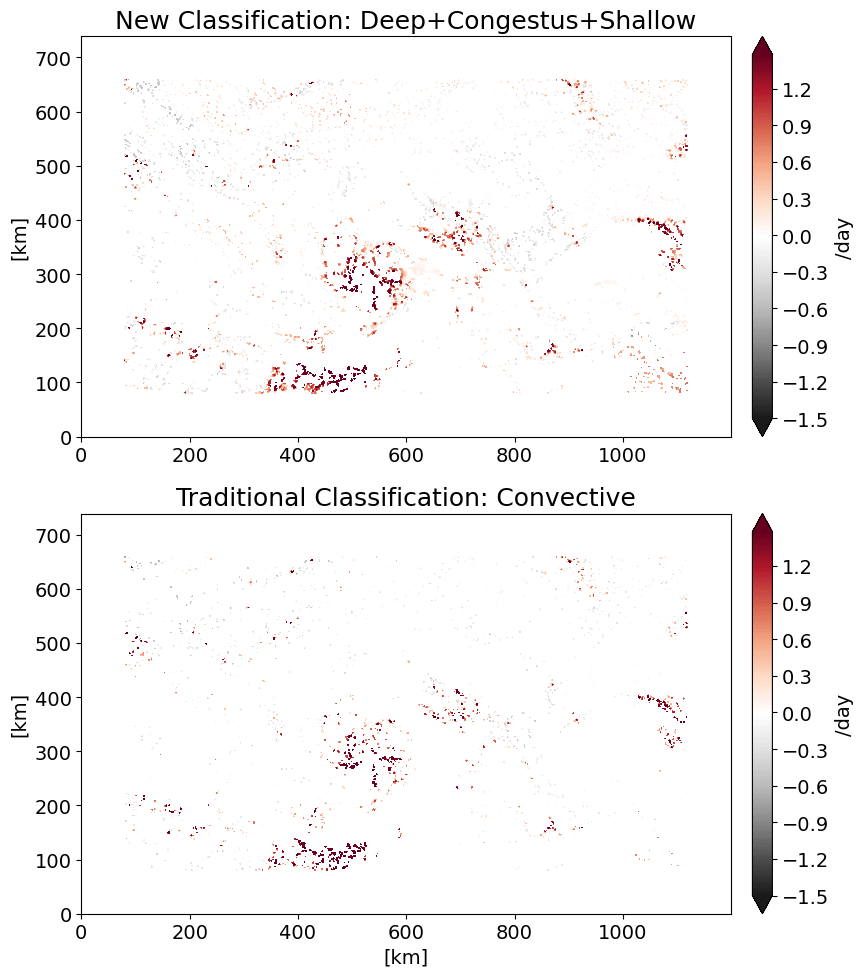

In [26]:
# Convective

fig = plt.figure(figsize=(12,10))
fig.set_facecolor('white')

clevs = np.arange(-1.5,1.5,0.02)

# New classification
lwmse_mask = np.ma.masked_where(((c_type == 0) | (c_type > 3)), lwmse, copy=True)
ax = fig.add_subplot(211,aspect='equal')
plt.contourf(lwmse_mask, clevs, cmap='RdGy_r', extend='both', zorder=1)
cbar=plt.colorbar(fraction=0.03, pad=0.02)
cbar.set_label('/day')
ax.set_ylabel('[km]')
ax.set_title("New Classification: Deep+Congestus+Shallow", size=18)

# Traditional classification
lwmse_mask = np.ma.masked_where((c_type_og != 1), lwmse, copy=True)
ax = fig.add_subplot(212,aspect='equal')
plt.contourf(lwmse_mask, clevs, cmap='RdGy_r', extend='both', zorder=1)
cbar=plt.colorbar(fraction=0.03, pad=0.02)
cbar.set_label('/day')
ax.set_xlabel('[km]')
ax.set_ylabel('[km]')
ax.set_title("Traditional Classification: Convective", size=18)

plt.tight_layout()

### Classification-averaged Vertical profiles
---

In [27]:
# Use mean p_hyd as vertical coordinate
pres = np.mean(p_hyd, axis=(1,2))*1e-2 # Pa --> hPa

In [28]:
# Function to plot class-averaged profiles
def plot_profiles_class(var_profile, precip_list, var_conv, var_strat, var_profile_og, xlabel, pres,
                        zeroline=True):
    
    fig = plt.figure(figsize=(12,8),facecolor='white')

    # Profile 1
    ax = fig.add_subplot(121)
    ax.plot(var_profile[0], pres, label=precip_list[0], color='blue')
    ax.plot(var_profile[1], pres, label=precip_list[1], color='red')
    ax.plot(var_profile[2], pres, label=precip_list[2], color='green')
    ax.plot(var_conv, pres, label='All', linestyle='--', color='black')
    ax.plot(var_profile_og[0], pres, label='Traditional', color='black')
    ax.set_title('Convective', size=16, weight='bold')
    plt.legend(loc='upper right', fontsize=12)
    plt.gca().invert_yaxis()
    if zeroline: ax.axvline(0, color='gray', linestyle='--')
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    ytick_loc=np.arange(1000,0,-100)
    plt.yticks(ticks=ytick_loc, size=12)
    plt.ylim(1000, 100)
    # plt.xlim(-0.25,1.25)
    plt.xticks(size=12)
    plt.xlabel(xlabel, size=14, weight='bold')
    plt.ylabel('Pressure [hPa]', size=14, weight='bold')

    # Profile 2
    ax = fig.add_subplot(122)
    ax.plot(var_profile[3], pres, label=precip_list[3], color='blue')
    ax.plot(var_profile[4], pres, label=precip_list[4], color='red')
    ax.plot(var_strat, pres, label='All', linestyle='--', color='black')
    ax.plot(var_profile_og[1], pres, label='Traditional', color='black')
    ax.set_title('Stratiform', size=16, weight='bold')
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    plt.legend(loc='upper right', fontsize=12)
    plt.gca().invert_yaxis()
    if zeroline: ax.axvline(0, color='gray', linestyle='--')
    plt.ylim(1000,100)
    # plt.xlim(-0.25,0.4)
    plt.yticks(ticks=ytick_loc, size=12)
    plt.ylim(1000, 100)
    plt.xticks(size=12)
    plt.xlabel(xlabel, size=14, weight='bold')
    plt.ylabel('Pressure [hPa]', size=14, weight='bold')

In [29]:
# Function to get class-averaged profiles
def var_profiles_class(var, c_type, c_type_og, pres, xlabel, zeroline=True):
    
    # New classification scheme
    precip_list = ['Deep', 'Congestus', 'Shallow', 'Stratiform', 'Anvil']
    n_class = len(precip_list)
    var_profile = np.ma.empty((n_class,nz))
    for t in range(n_class):
        ind = (c_type == t+1).nonzero()
        var_profile[t,:] = np.ma.mean(var[:,ind[0],ind[1]], axis=1)
    
    ind = ((c_type > 0) & (c_type < 4)).nonzero()
    var_conv = np.ma.mean(var[:,ind[0],ind[1]], axis=1) # convective total
    ind = (c_type > 3).nonzero()
    var_strat = np.ma.mean(var[:,ind[0],ind[1]], axis=1) # stratiform total

    # Traditional classification scheme
    precip_list_og = ['conv', 'strat', 'mixed']
    n_class_og = len(precip_list_og)
    var_profile_og = np.ma.empty((n_class_og,nz))
    for t in range(n_class_og):
        ind = (c_type_og == t+1).nonzero()
        var_profile_og[t,:] = np.ma.mean(var[:,ind[0],ind[1]], axis=1)
    
    plot_profiles_class(var_profile, precip_list, var_conv, var_strat, var_profile_og, xlabel, pres,
                        zeroline)

#### Average w-profiles

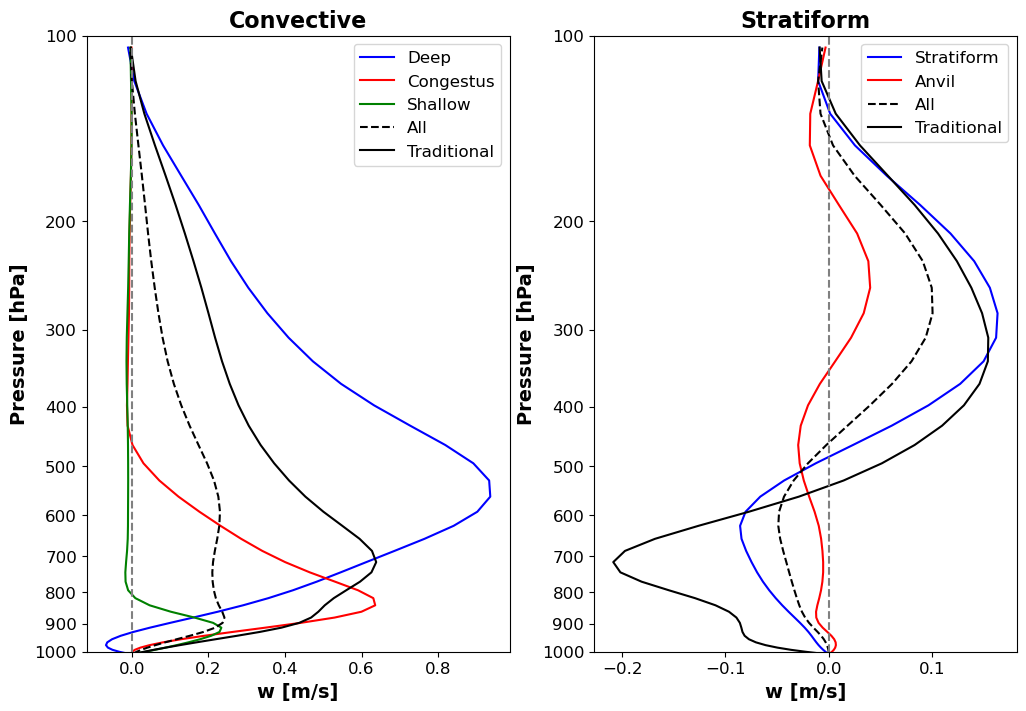

In [30]:
# w profile
var = np.copy(w)
xlabel = 'w [m/s]'
var_profiles_class(var, c_type, c_type_og, pres, xlabel)

#### Avg cloud–radiation forcing profiles

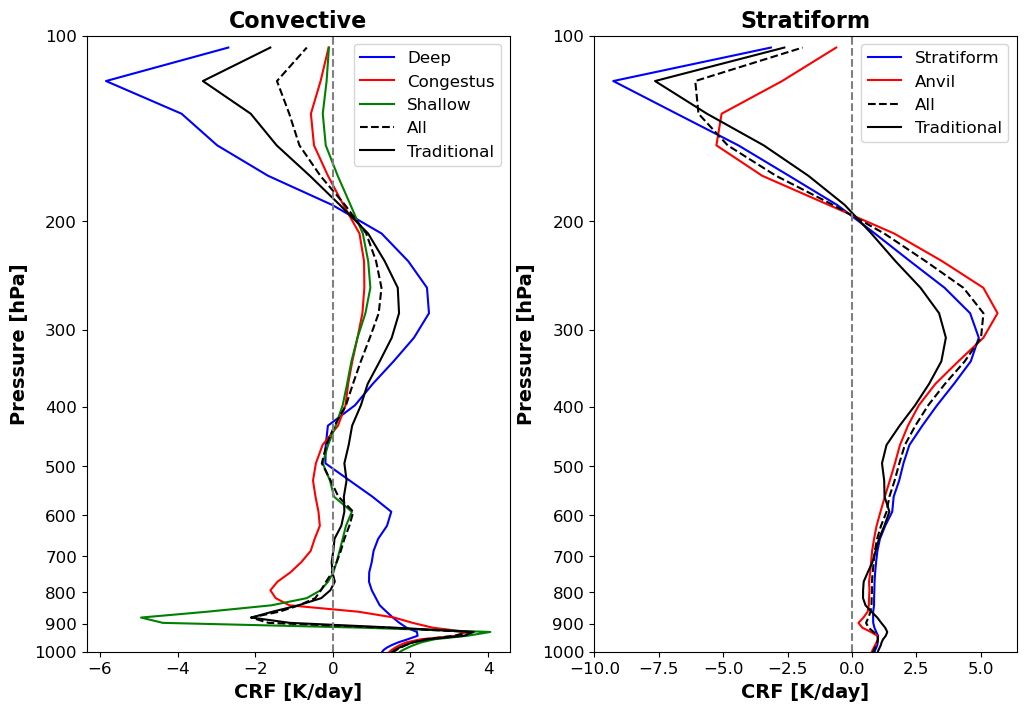

In [31]:
var = np.copy(crf)
xlabel = 'CRF [K/day]'
var_profiles_class(var, c_type, c_type_og, pres, xlabel)

#### Avg cloud hydrometeor profiles

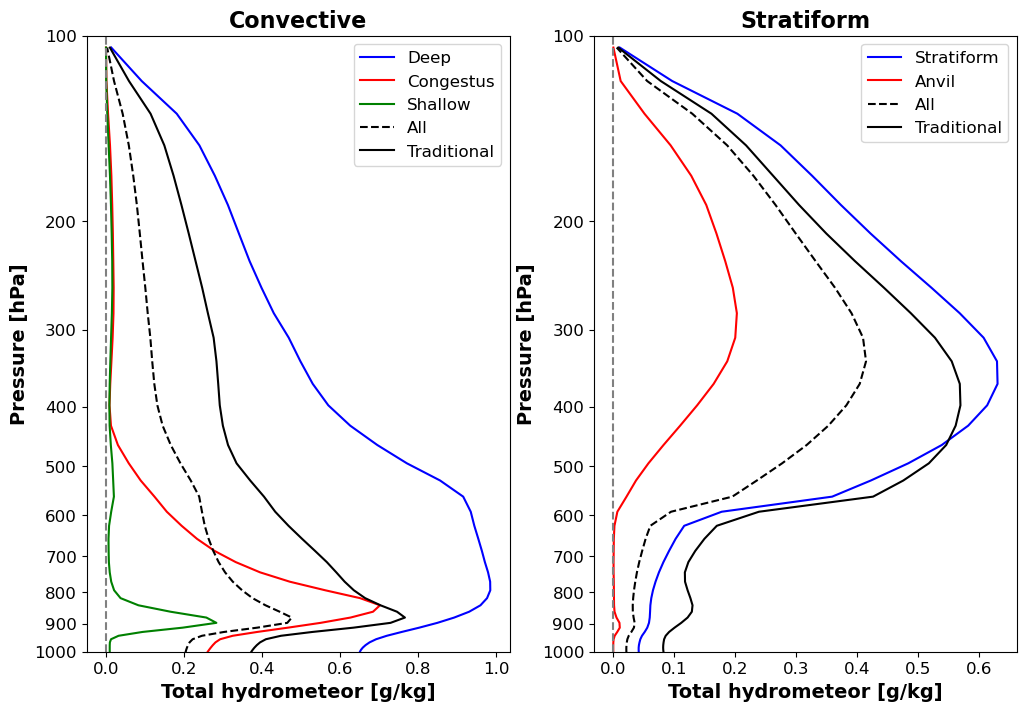

In [32]:
qice = q_var[0]+q_var[1] # [kg/kg]; cloud + rain
qliq = q_var[2]+q_var[3]+q_var[4] # [kg/kg]; ice + snow + graupel
var = qliq+qice
var = np.copy(var)*1e3
xlabel = 'Total hydrometeor [g/kg]'
var_profiles_class(var, c_type, c_type_og, pres, xlabel)

#### MSE / Gross Moist Stability Analysis
---

In [33]:
def calc_vadv(w, rho, var, pres):
    # Gradient terms (Inoue and Back 2015):
    #   VADV_SUM = < omeg * dVAR/dp >
    g = 9.81 # m/s^2
    omeg = w * (-1)*g*rho
    vadv = omeg * np.gradient(var,pres,axis=0)
    return vadv

In [34]:
# Function to get class-averaged profiles
def var_mean_2d(var):
    
    # New classification scheme
    precip_list = ['Deep', 'Congestus', 'Shallow', 'Stratiform', 'Anvil']
    n_class = len(precip_list)
    for t in range(n_class):
        ind = (c_type == t+1).nonzero()
        print(precip_list[t],': ',
              np.ma.mean(var[ind[0],ind[1]]))
    
    ind = ((c_type > 0) & (c_type < 4)).nonzero()
    print('Conv: ',np.ma.mean(var[ind[0],ind[1]])) # convective total
    ind = (c_type > 3).nonzero()
    print('Strat: ',np.ma.mean(var[ind[0],ind[1]])) # stratiform total

    # # Traditional classification scheme
    # precip_list_og = ['conv', 'strat', 'mixed']
    # n_class_og = len(precip_list_og)
    # var_profile_og = np.ma.empty((n_class_og,nz))
    # for t in range(n_class_og):
    #     ind = (c_type_og == t+1).nonzero()
    #     var_profile_og[t,:] = np.ma.mean(var[:,ind[0],ind[1]], axis=1)

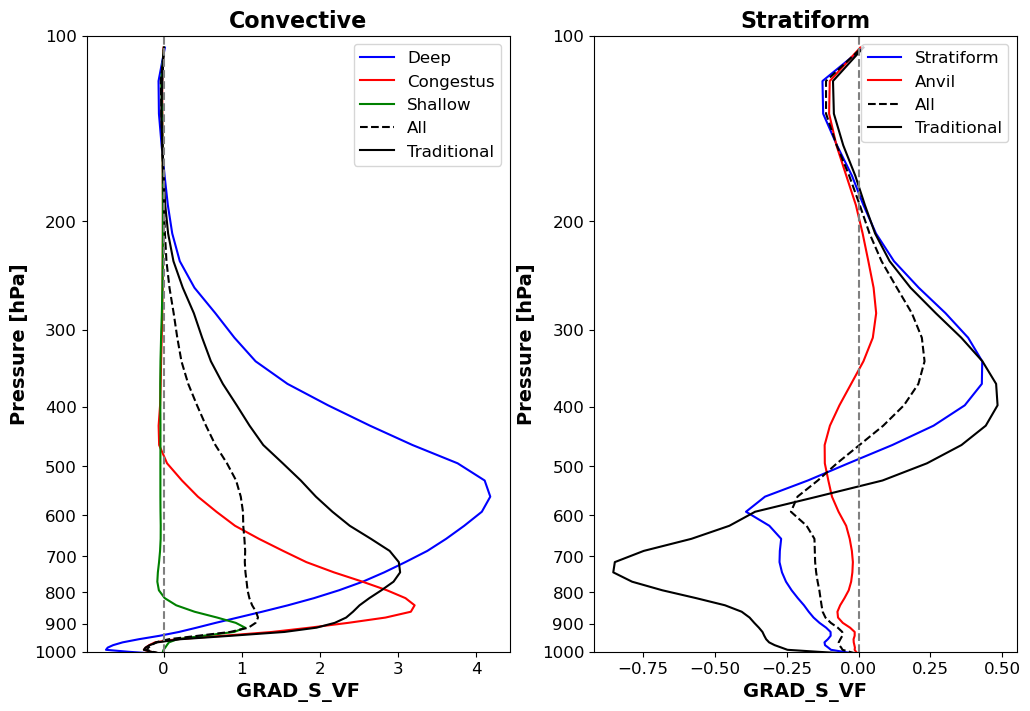

In [35]:
# Additional necessary variables
grad_s_vf = calc_vadv(w, rho, dse_z, pres*1e2)
var = np.copy(grad_s_vf)
xlabel = 'GRAD_S_VF'
var_profiles_class(var, c_type, c_type_og, pres, xlabel)

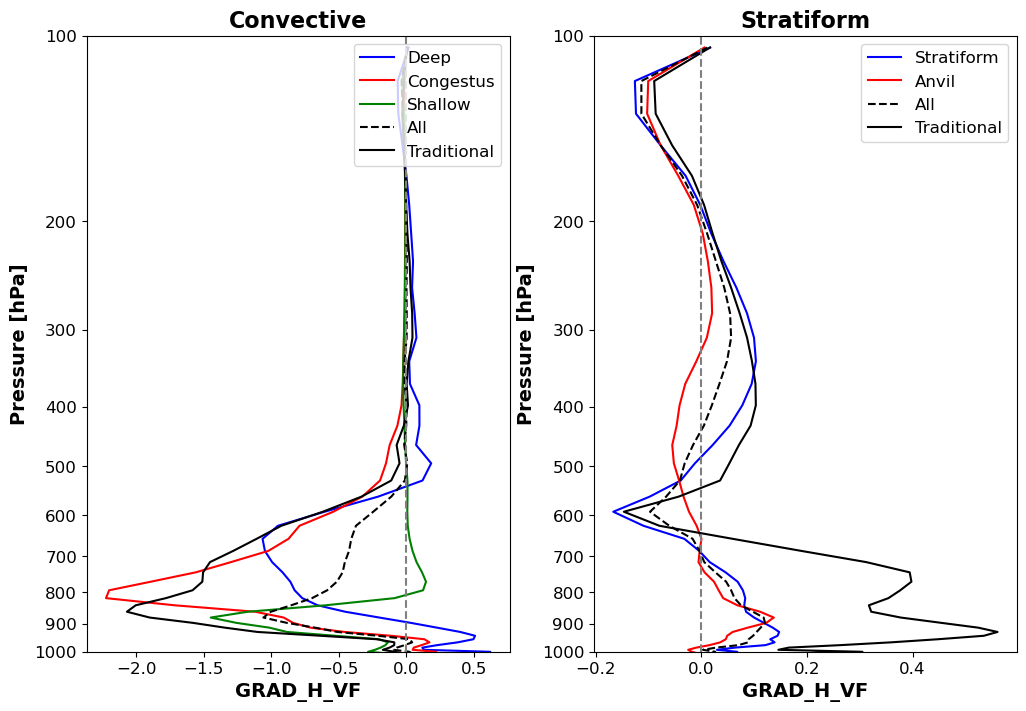

In [36]:
# Additional necessary variables
grad_h_vf = calc_vadv(w, rho, mse_z, pres*1e2)
var = np.copy(grad_h_vf)
xlabel = 'GRAD_H_VF'
var_profiles_class(var, c_type, c_type_og, pres, xlabel)

In [38]:
grad_h_vint = vertical_int(grad_h_vf, dp)
var_mean_2d(grad_h_vint)

Deep :  -2025.5970100032978
Congestus :  -4771.910684380931
Shallow :  -1253.6260176463065
Stratiform :  247.6359838367235
Anvil :  -10.729302743305029
Conv:  -2181.866409731422
Strat:  122.19499647639182


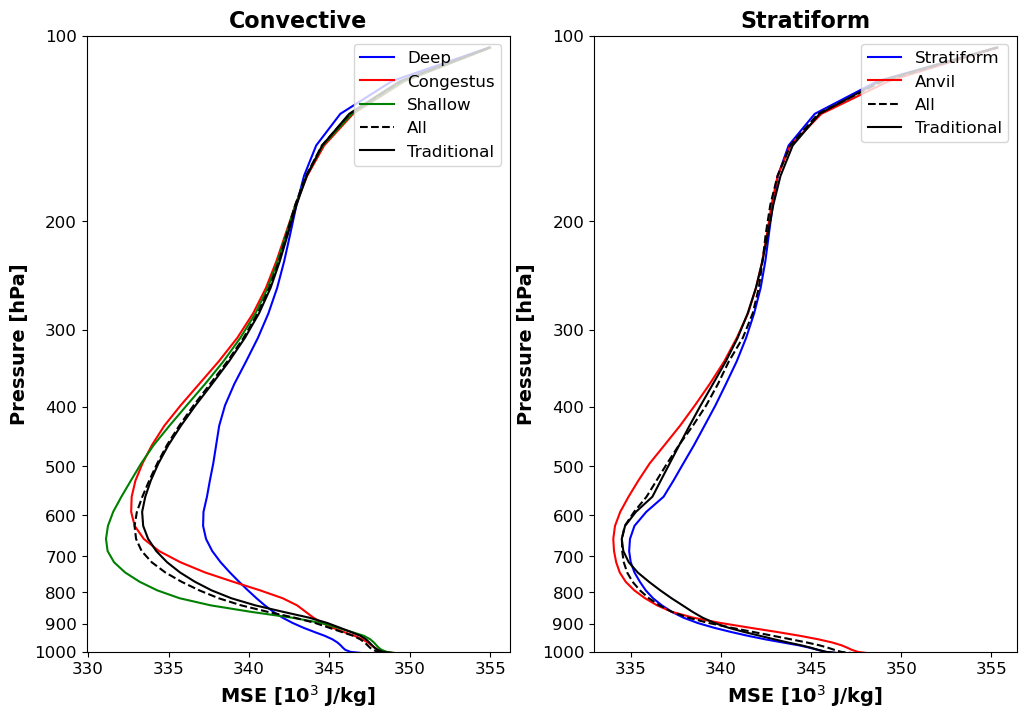

In [39]:
var = np.copy(mse_z)*1e-3
xlabel = 'MSE [10$^3$ J/kg]'
var_profiles_class(var, c_type, c_type_og, pres, xlabel, zeroline=False)

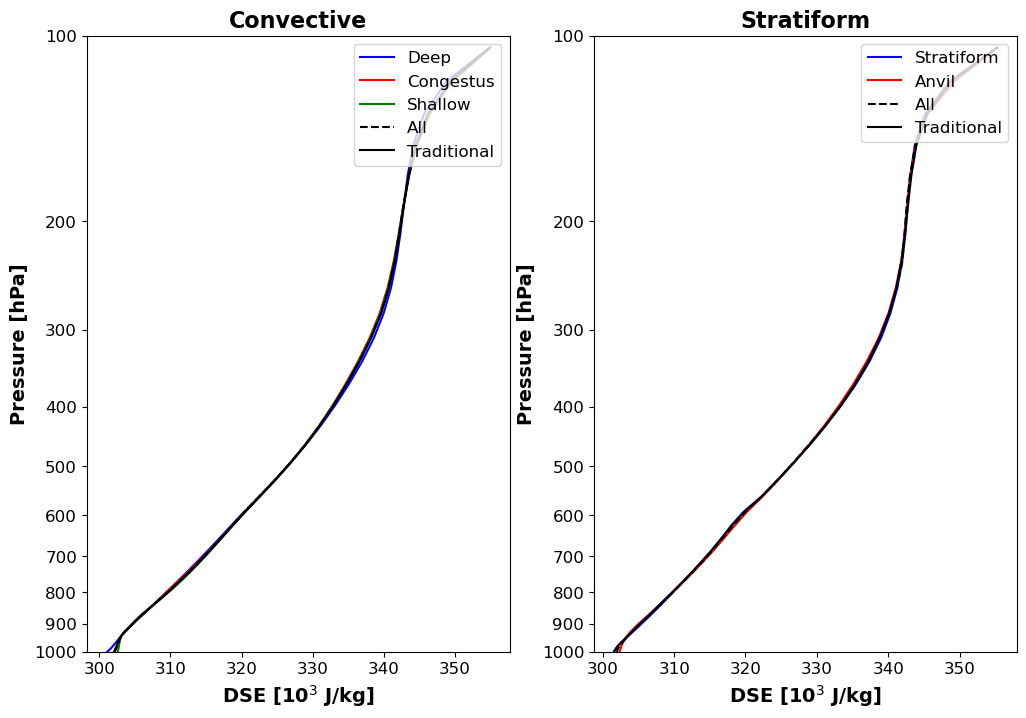

In [40]:
var = np.copy(dse_z)*1e-3
xlabel = 'DSE [10$^3$ J/kg]'
var_profiles_class(var, c_type, c_type_og, pres, xlabel, zeroline=False)